In [ ]:
import psycopg2

API_KEY = '2CDC7D3628A900A6E59E9BC19A8E0B62'

try:
    connection = psycopg2.connect(
        host="26.84.71.27",       
        database="DataScienceProj",
        user="postgres",     
        password="SteamDB",    
        port="5432",
        options="-c client_encoding=UTF8"  
    )

    cursor = connection.cursor()

    cursor.execute("SELECT version();")
    version = cursor.fetchone()
    print("Versão do PostgreSQL:", version)

except Exception as error:
    print("Erro ao conectar ao banco de dados:", str(error).encode('utf-8', errors='replace').decode())


C:\Users\mag\AppData\Local\Temp\ipykernel_16940\4063116891.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(query, connection)
C:\Users\mag\AppData\Local\Temp\ipykernel_16940\4063116891.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='qtdejogos', y='description', palette='viridis')


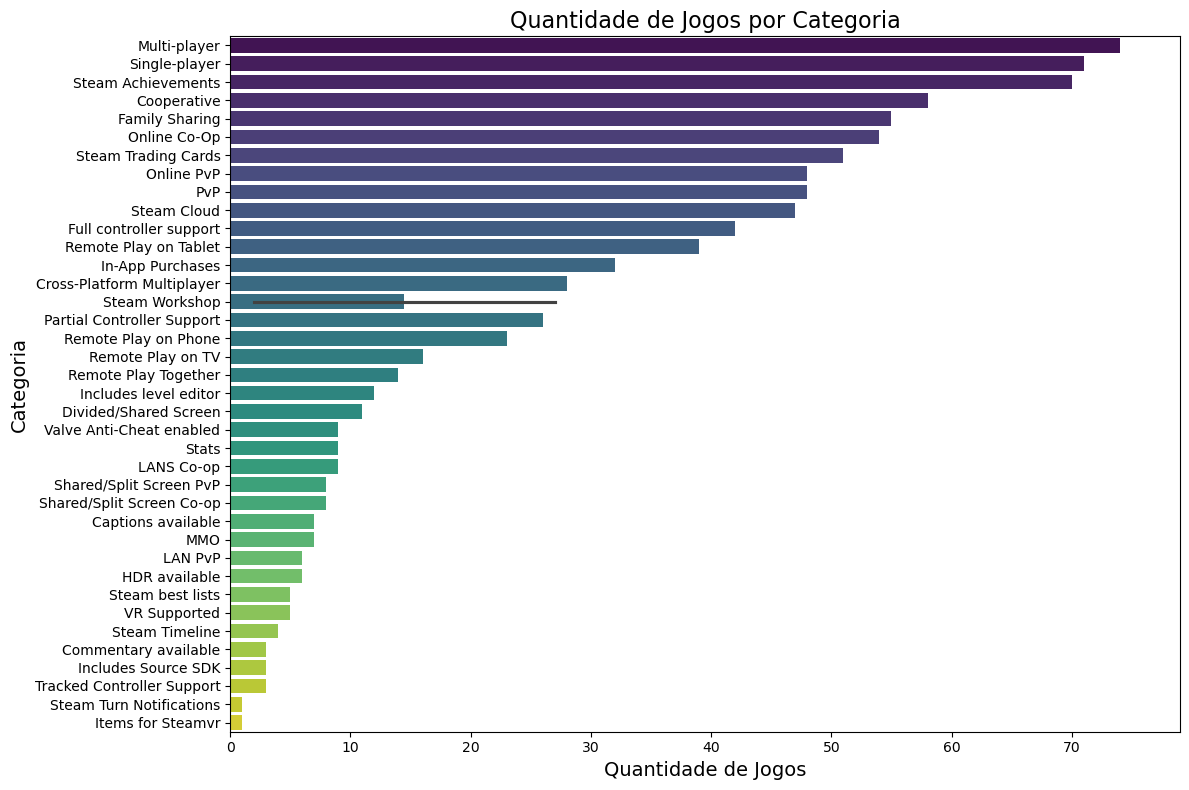

In [4]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

connection = psycopg2.connect(
       host="26.84.71.27",       
       database="DataScienceProj",
       user="postgres",     
       password="SteamDB",    
       port="5432",
       options="-c client_encoding=UTF8"  
)

cursor = connection.cursor()

query = """
SELECT DISTINCT id, 
       (SELECT description 
        FROM steam.games_categories_steam cat 
        WHERE cat.id = a.id LIMIT 1) AS description, 
       qtdejogos 
FROM (
    SELECT DISTINCT id, 
           gcs.description, 
           COUNT(appid) OVER (PARTITION BY gcs.id) AS qtdejogos
    FROM steam.games_categories_steam gcs
) AS a 
ORDER BY qtdejogos DESC
"""
data = pd.read_sql_query(query, connection)

connection.close()
plt.figure(figsize=(12, 8))
sns.barplot(data=data, x='qtdejogos', y='description', palette='viridis')
plt.title("Quantidade de Jogos por Categoria", fontsize=16)
plt.xlabel("Quantidade de Jogos", fontsize=14)
plt.ylabel("Categoria", fontsize=14)
plt.xlim(0, data['qtdejogos'].max() + 5) 

plt.tight_layout()

plt.show()

C:\Users\mag\AppData\Local\Temp\ipykernel_16940\1159161248.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(query, connection)
C:\Users\mag\AppData\Local\Temp\ipykernel_16940\1159161248.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x='PEAK_IN_GAME', y='NAME', palette='viridis')


Conexão encerrada.
                  name  last_week_rank  peak_in_game
0     Counter-Strike 2               1      1544.831
1  PUBG: BATTLEGROUNDS               3       777.329
2               Dota 2               2       751.298
3     Wallpaper Engine               4       136.116
4        Call of Duty®               5       203.669


C:\Users\mag\AppData\Local\Temp\ipykernel_16940\1159161248.py:61: UserWarning: Glyph 21629 (\N{CJK UNIFIED IDEOGRAPH-547D}) missing from current font.
  plt.tight_layout()
C:\Users\mag\AppData\Local\Temp\ipykernel_16940\1159161248.py:61: UserWarning: Glyph 36816 (\N{CJK UNIFIED IDEOGRAPH-8FD0}) missing from current font.
  plt.tight_layout()
c:\Users\mag\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21629 (\N{CJK UNIFIED IDEOGRAPH-547D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\mag\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36816 (\N{CJK UNIFIED IDEOGRAPH-8FD0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


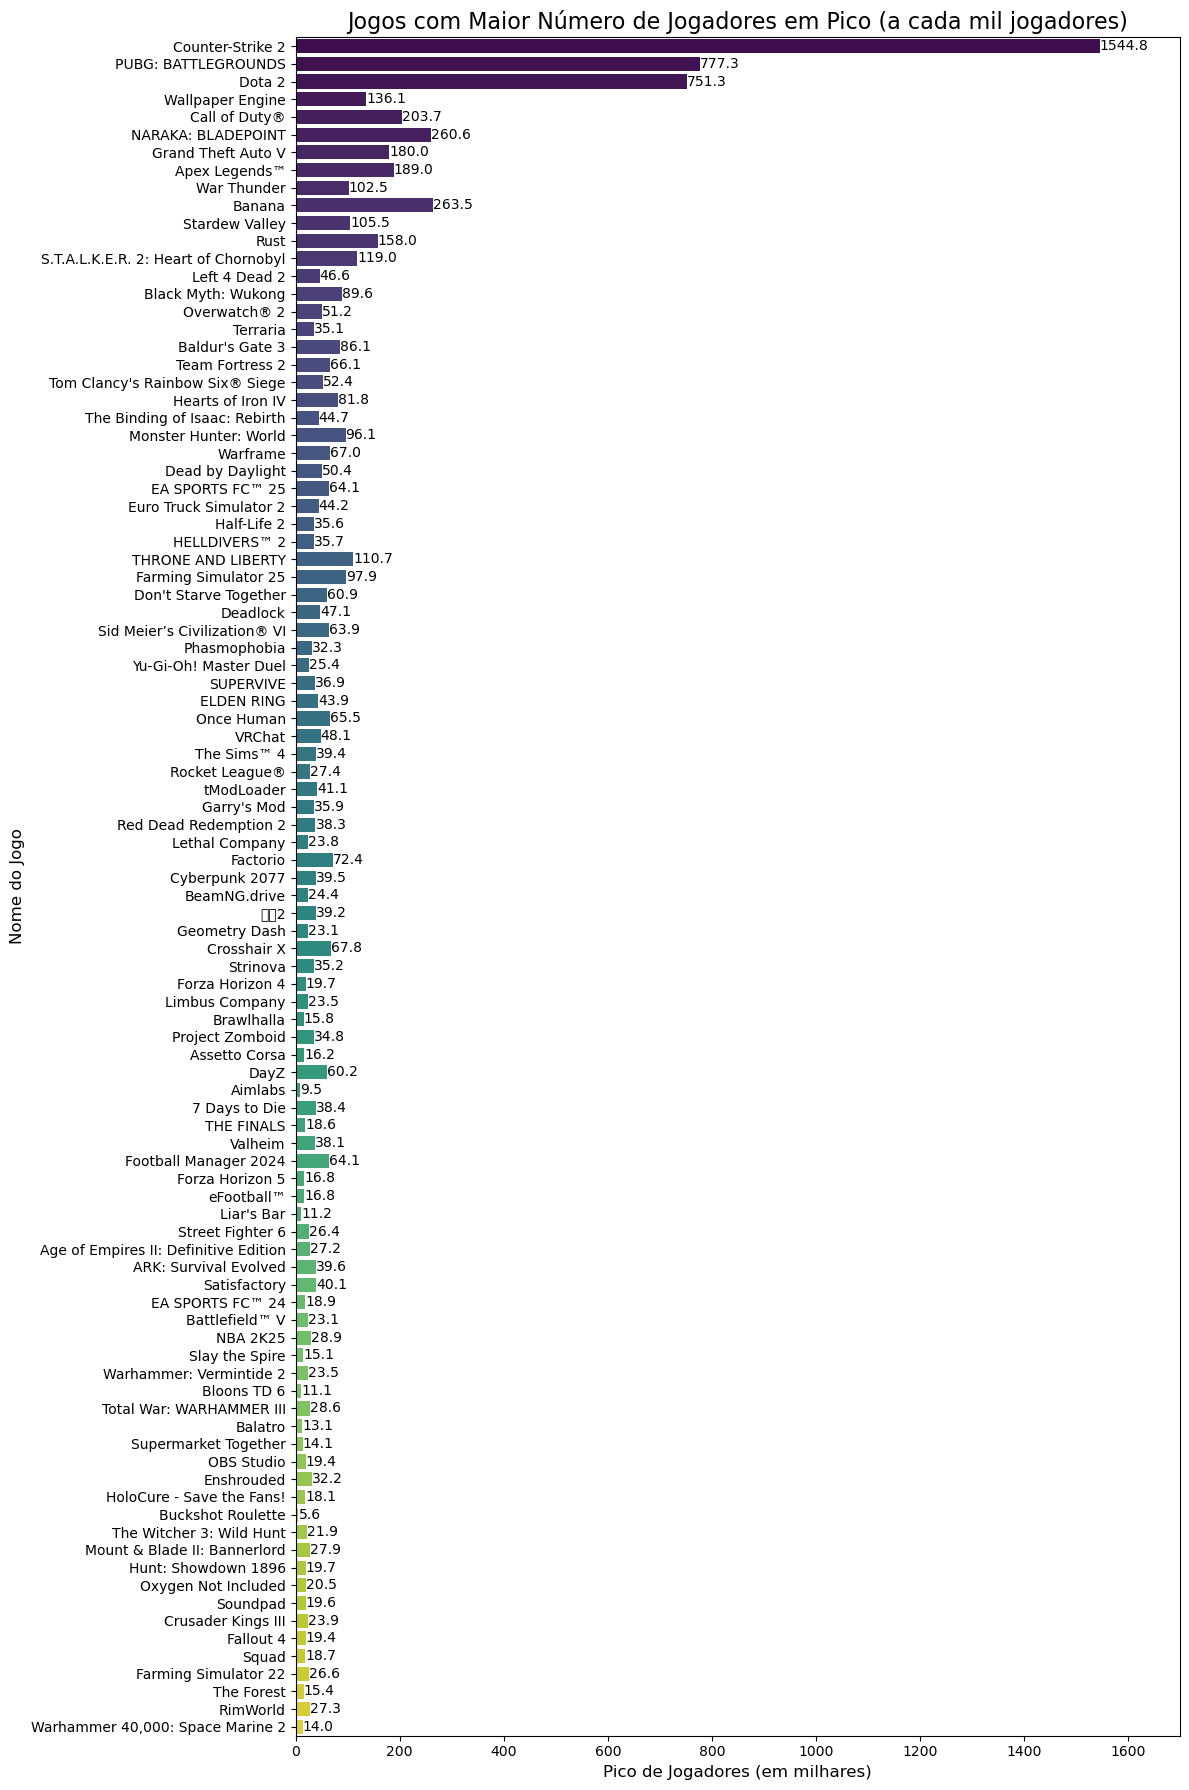

In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

connection = psycopg2.connect(
    host="26.84.71.27",       
    database="DataScienceProj",
    user="postgres",     
    password="SteamDB",    
    port="5432",
    options="-c client_encoding=UTF8"  
)

cursor = connection.cursor()


if connection:
    # Definir a consulta SQL
    query = """
    SELECT GI.NAME, 
           G.last_week_rank, 
           (cast(G.peak_in_game as float) / 1000) as peak_in_game
    FROM STEAM.GAMES G
    JOIN STEAM.GAME_INFO GI ON G.APPID = GI.steam_appid
    ORDER BY RANK
    """

    try:
        # Executar a consulta e carregar os dados em um DataFrame
        data = pd.read_sql_query(query, connection)
        connection.close()
        print("Conexão encerrada.")

        # Verificar o DataFrame
        if data.empty:
            print("O DataFrame está vazio. Verifique sua consulta SQL.")
        else:
            print(data.head())  # Exibir as primeiras linhas

            # Certificar-se de que as colunas têm os nomes corretos
            data.columns = [col.strip().upper() for col in data.columns]

            # Plotar o gráfico
            plt.figure(figsize=(12, 18))
            sns.barplot(data=data, x='PEAK_IN_GAME', y='NAME', palette='viridis')

            # Adicionar rótulos com os valores reais
            for index, value in enumerate(data['PEAK_IN_GAME']):
                plt.text(value, index, f"{value:.1f}", va='center', fontsize=10)

            # Configurar título e rótulos
            plt.title("Jogos com Maior Número de Jogadores em Pico (a cada mil jogadores)", fontsize=16)
            plt.xlabel("Pico de Jogadores (em milhares)", fontsize=12)
            plt.ylabel("Nome do Jogo", fontsize=12)

            # Ajustar limites do eixo X automaticamente
            max_peak = data['PEAK_IN_GAME'].max()
            plt.xlim(0, max_peak * 1.1)  # Adicionar 10% de margem

            plt.tight_layout()

            # Exibir o gráfico
            plt.show()
    except Exception as e:
        print(f"Erro ao executar a consulta ou gerar o gráfico: {e}")


Tabela salva como 'tabela_jogos.png'.


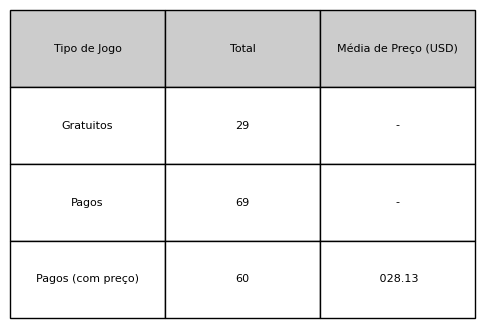

In [8]:

import psycopg2
import matplotlib.pyplot as plt
from matplotlib.table import Table


query = """SELECT 'Gratuitos' AS tipo_jogo, COUNT(*) AS total, '-' as media_preço
FROM steam.game_info
WHERE is_free = true
UNION ALL
SELECT 'Pagos' AS tipo_jogo, COUNT(*) AS total, '-' as media_preço
FROM steam.game_info gi
WHERE is_free = false
union all 
select 'Pagos (com preço)' AS tipo_jogo, COUNT(*) AS total, to_char((select avg(initial) from steam.game_prices gp ), '000.00') as media_preco
from steam.game_info gi 
join steam.game_prices gp on gp.appid =gi.steam_appid 
;
"""

try:
    # Conectar ao banco de dados
    connection = psycopg2.connect(
        host="26.84.71.27",       
        database="DataScienceProj",
        user="postgres",     
        password="SteamDB",    
        port="5432",
        options="-c client_encoding=UTF8"  
    )

    cursor = connection.cursor()

    cursor.execute(query)

    results = cursor.fetchall()
    # Dados para a tabela
    headers = ["Tipo de Jogo", "Total", "Média de Preço (USD)"]
    data = results

    # Criar a figura
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis("off")  # Desativar os eixos

    # Criar a tabela
    table = Table(ax, bbox=[0, 0, 1, 1])  # Coordenadas da tabela
    cell_colors = [["#f0f0f0", "#f0f0f0"]] + [["#ffffff", "#ffffff"] for _ in data]

    # Adicionar cabeçalhos
    for i, header in enumerate(headers):
        table.add_cell(0, i, width=0.5, height=0.2, text=header, loc="center", facecolor="#cccccc")

    # Adicionar os dados
    for row_idx, row in enumerate(data, start=1):
        for col_idx, cell in enumerate(row):
            table.add_cell(row_idx, col_idx, width=0.5, height=0.2, text=str(cell), loc="center", facecolor="#ffffff")

    # Adicionar tabela ao eixo
    ax.add_table(table)

    # Salvar como imagem
    plt.savefig("tabela_jogos.png", dpi=300)
    print("Tabela salva como 'tabela_jogos.png'.")

except Exception as e:
    print("Erro ao conectar ou executar a consulta:", e)
finally:
    # Fechar conexão
    if cursor:
        cursor.close()
    if connection:
        connection.close()

C:\Users\mag\AppData\Local\Temp\ipykernel_16940\3627957017.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_free = pd.read_sql_query(query_free, connection)
C:\Users\mag\AppData\Local\Temp\ipykernel_16940\3627957017.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_pay = pd.read_sql_query(query_pay, connection)
C:\Users\mag\AppData\Local\Temp\ipykernel_16940\3627957017.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data_free, x='qtdejogos', y='description', palette='Blues_r')
C:\Users\mag\AppData\Local

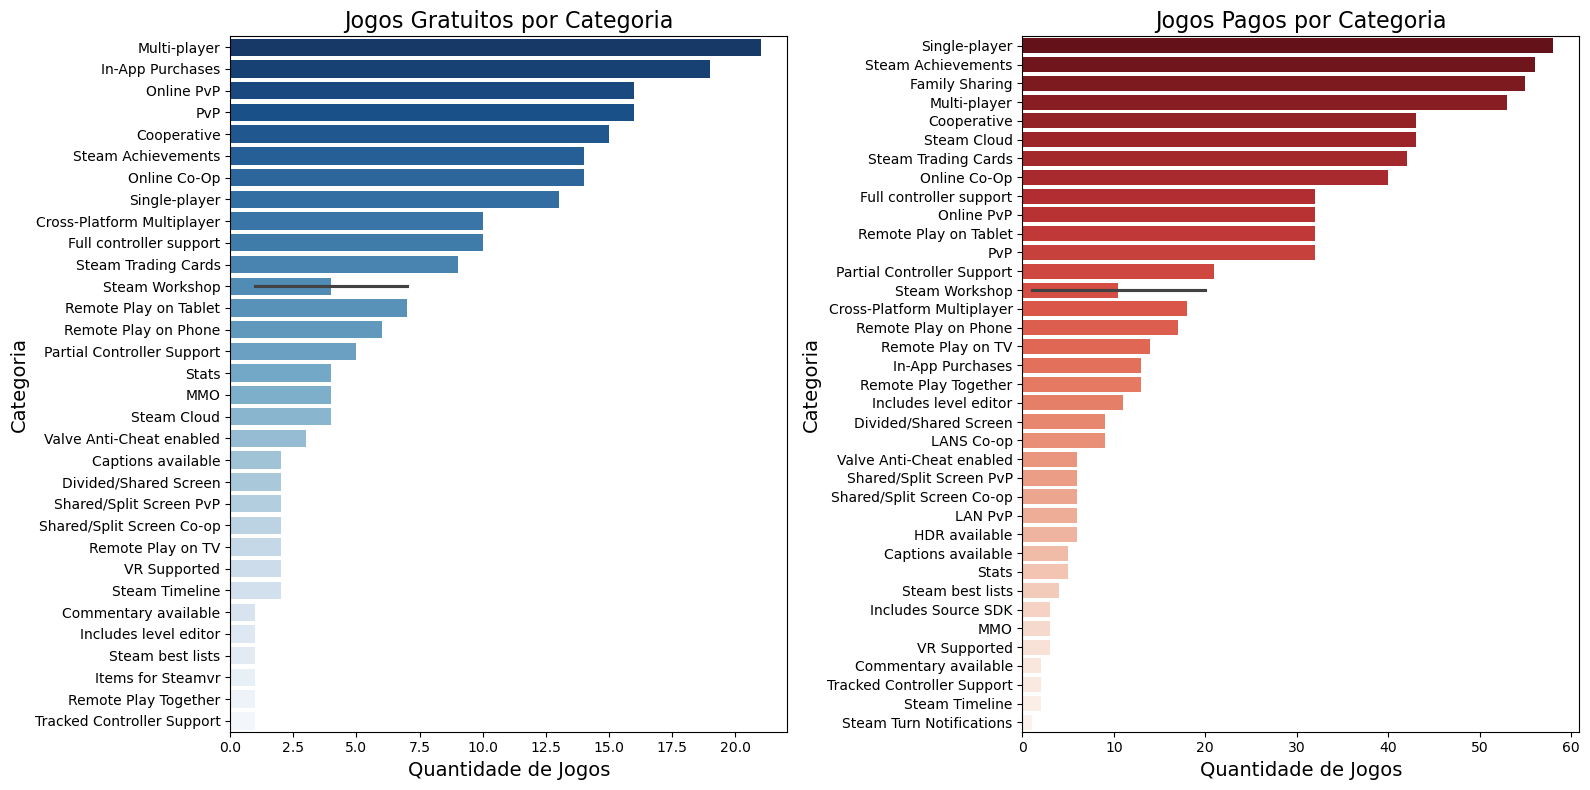

In [ ]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Conexão com o banco de dados
connection = psycopg2.connect(
    host="26.84.71.27",
    database="DataScienceProj",
    user="postgres",
    password="SteamDB",
    port="5432",
    options="-c client_encoding=UTF8"
)

# Executando as consultas
query_free = """
SELECT DISTINCT id, 
       (SELECT description 
        FROM steam.games_categories_steam cat 
        WHERE cat.id = a.id LIMIT 1) AS description, 
       qtdejogos 
FROM (
    SELECT DISTINCT gcs.id, 
           gcs.description, 
           COUNT(appid) OVER (PARTITION BY gcs.id) AS qtdejogos
    FROM steam.games_categories_steam gcs
    join steam.game_info gi on gi.steam_appid = gcs.appid
    where gi.is_free = true
) AS a 
ORDER BY qtdejogos desc
"""

query_pay = """
SELECT DISTINCT id, 
       (SELECT description 
        FROM steam.games_categories_steam cat 
        WHERE cat.id = a.id LIMIT 1) AS description, 
       qtdejogos 
FROM (
    SELECT DISTINCT gcs.id, 
           gcs.description, 
           COUNT(appid) OVER (PARTITION BY gcs.id) AS qtdejogos
    FROM steam.games_categories_steam gcs
    join steam.game_info gi on gi.steam_appid = gcs.appid
    where gi.is_free = false
) AS a 
ORDER BY qtdejogos desc
"""

# Lendo os dados
data_free = pd.read_sql_query(query_free, connection)
data_pay = pd.read_sql_query(query_pay, connection)

# Fechando a conexão
connection.close()

# Criando os gráficos lado a lado
plt.figure(figsize=(16, 8))

# Gráfico para jogos gratuitos
plt.subplot(1, 2, 1)
sns.barplot(data=data_free, x='qtdejogos', y='description', palette='Blues_r')
plt.title("Jogos Gratuitos por Categoria", fontsize=16)
plt.xlabel("Quantidade de Jogos", fontsize=14)
plt.ylabel("Categoria", fontsize=14)

# Gráfico para jogos pagos
plt.subplot(1, 2, 2)
sns.barplot(data=data_pay, x='qtdejogos', y='description', palette='Reds_r')
plt.title("Jogos Pagos por Categoria", fontsize=16)
plt.xlabel("Quantidade de Jogos", fontsize=14)
plt.ylabel("Categoria", fontsize=14)

# Ajustando o layout
plt.tight_layout()
plt.show()


Tabela salva como 'tabela_jogos.png'.


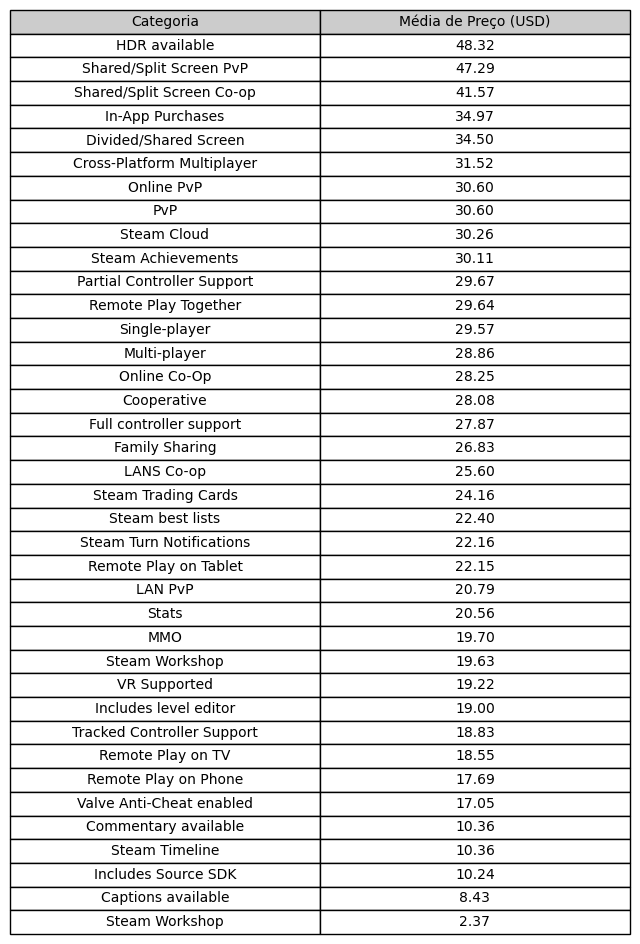

In [13]:
import psycopg2
import matplotlib.pyplot as plt
from matplotlib.table import Table

query = """
SELECT DISTINCT 
       (SELECT description 
        FROM steam.games_categories_steam cat 
        WHERE cat.id = gcs.id LIMIT 1) AS description, 
        avg(gp.initial) OVER (PARTITION BY gcs.id) preco_medio
FROM steam.games_categories_steam gcs
JOIN steam.game_info gi ON gi.steam_appid = gcs.appid
JOIN steam.game_prices gp ON gp.appid = gi.steam_appid
ORDER BY preco_medio DESC
"""

try:
    # Conectar ao banco de dados
    connection = psycopg2.connect(
        host="26.84.71.27",       
        database="DataScienceProj",
        user="postgres",     
        password="SteamDB",    
        port="5432",
        options="-c client_encoding=UTF8"  
    )

    cursor = connection.cursor()

    cursor.execute(query)

    results = cursor.fetchall()
    # Dados para a tabela
    headers = ["Categoria", "Média de Preço (USD)"]
    data = results

    # Criar a figura
    fig, ax = plt.subplots(figsize=(8,12))
    ax.axis("off")  # Desativar os eixos

    # Criar a tabela
    table = Table(ax, bbox=[0, 0, 1, 1])  # Coordenadas da tabela

    # Adicionar cabeçalhos
    for i, header in enumerate(headers):
        table.add_cell(0, i, width=0.5, height=0.2, text=header, loc="center", facecolor="#cccccc")

    # Adicionar os dados
    for row_idx, row in enumerate(data, start=1):
        description, preco_medio = row
        table.add_cell(row_idx, 0, width=0.5, height=0.2, text=str(description), loc="center", facecolor="#ffffff")
        table.add_cell(row_idx, 1, width=0.5, height=0.2, text=f"{preco_medio:.2f}", loc="center", facecolor="#ffffff")

    # Adicionar tabela ao eixo
    ax.add_table(table)

    # Salvar como imagem
    plt.savefig("tabela_jogos.png", dpi=300)
    print("Tabela salva como 'tabela_jogos.png'.")

except Exception as e:
    print("Erro ao conectar ou executar a consulta:", e)
finally:
    # Fechar conexão
    if cursor:
        cursor.close()
    if connection:
        connection.close()


Tabela salva como 'tabela_jogos.png'.


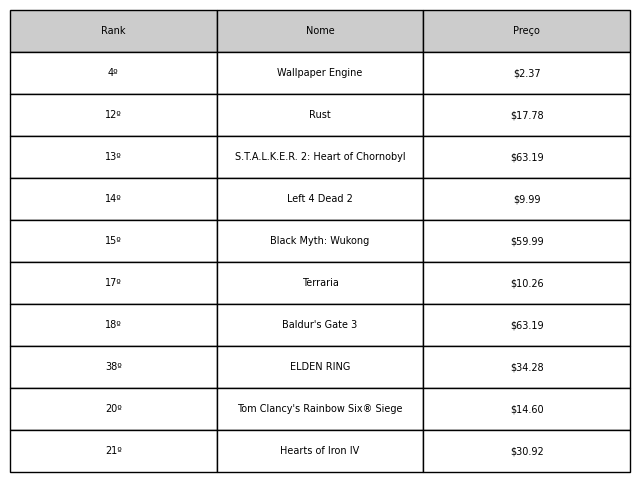

In [17]:

import psycopg2
import matplotlib.pyplot as plt
from matplotlib.table import Table


query = """select rank || 'º', gi."name", '$'|| gp.initial as price from steam.games g
join steam.game_info gi on gi.steam_appid = g.appid
join steam.game_prices gp on gp.appid = gi.steam_appid 
where is_free = false
limit 10
"""

try:
    # Conectar ao banco de dados
    connection = psycopg2.connect(
        host="26.84.71.27",       
        database="DataScienceProj",
        user="postgres",     
        password="SteamDB",    
        port="5432",
        options="-c client_encoding=UTF8"  
    )

    cursor = connection.cursor()

    cursor.execute(query)

    results = cursor.fetchall()
    # Dados para a tabela
    headers = ["Rank", "Nome", "Preço"]
    data = results

    # Criar a figura
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis("off")  # Desativar os eixos

    # Criar a tabela
    table = Table(ax, bbox=[0, 0, 1, 1])  # Coordenadas da tabela
    cell_colors = [["#f0f0f0", "#f0f0f0"]] + [["#ffffff", "#ffffff"] for _ in data]

    # Adicionar cabeçalhos
    for i, header in enumerate(headers):
        table.add_cell(0, i, width=0.5, height=0.2, text=header, loc="center", facecolor="#cccccc")

    # Adicionar os dados
    for row_idx, row in enumerate(data, start=1):
        for col_idx, cell in enumerate(row):
            table.add_cell(row_idx, col_idx, width=0.5, height=0.2, text=str(cell), loc="center", facecolor="#ffffff")

    # Adicionar tabela ao eixo
    ax.add_table(table)

    # Salvar como imagem
    plt.savefig("tabela_jogos.png", dpi=300)
    print("Tabela salva como 'tabela_jogos.png'.")

except Exception as e:
    print("Erro ao conectar ou executar a consulta:", e)
finally:
    # Fechar conexão
    if cursor:
        cursor.close()
    if connection:
        connection.close()